In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
import numpy as np

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
for x in range(len(signals_all)):
    # if x == 0:
    print("'" + signals_all[x] + "',")
    


'2Mu2E_100GeV_0p25GeV_0p02mm',
'2Mu2E_100GeV_0p25GeV_0p2mm',
'2Mu2E_100GeV_0p25GeV_2p0mm',
'2Mu2E_100GeV_0p25GeV_10p0mm',
'2Mu2E_100GeV_0p25GeV_20p0mm',
'2Mu2E_100GeV_1p2GeV_0p096mm',
'2Mu2E_100GeV_1p2GeV_0p96mm',
'2Mu2E_100GeV_1p2GeV_9p6mm',
'2Mu2E_100GeV_1p2GeV_48p0mm',
'2Mu2E_100GeV_1p2GeV_96p0mm',
'2Mu2E_100GeV_5p0GeV_0p4mm',
'2Mu2E_100GeV_5p0GeV_4p0mm',
'2Mu2E_100GeV_5p0GeV_40p0mm',
'2Mu2E_100GeV_5p0GeV_200mm',
'2Mu2E_100GeV_5p0GeV_400mm',
'2Mu2E_150GeV_0p25GeV_0p013mm',
'2Mu2E_150GeV_0p25GeV_0p13mm',
'2Mu2E_150GeV_0p25GeV_1p3mm',
'2Mu2E_150GeV_0p25GeV_6p7mm',
'2Mu2E_150GeV_0p25GeV_13p0mm',
'2Mu2E_150GeV_1p2GeV_0p064mm',
'2Mu2E_150GeV_1p2GeV_0p64mm',
'2Mu2E_150GeV_1p2GeV_6p4mm',
'2Mu2E_150GeV_1p2GeV_32p0mm',
'2Mu2E_150GeV_1p2GeV_64p0mm',
'2Mu2E_150GeV_5p0GeV_0p27mm',
'2Mu2E_150GeV_5p0GeV_2p7mm',
'2Mu2E_150GeV_5p0GeV_27p0mm',
'2Mu2E_150GeV_5p0GeV_130p0mm',
'2Mu2E_150GeV_5p0GeV_270p0mm',
'2Mu2E_200GeV_0p25GeV_0p01mm',
'2Mu2E_200GeV_0p25GeV_0p1mm',
'2Mu2E_200GeV_0p25GeV_1p0mm',
'2Mu2

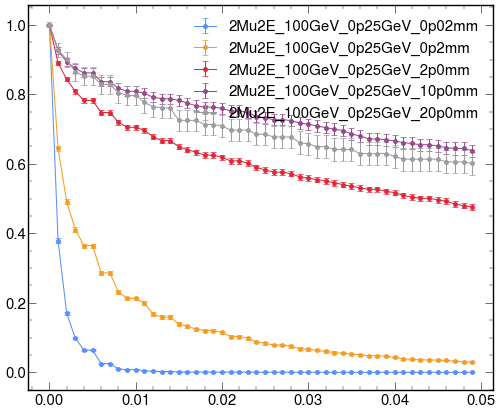

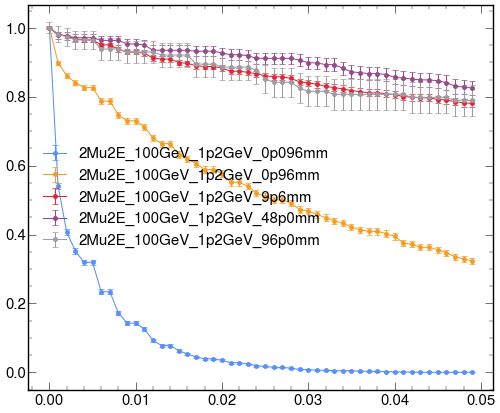

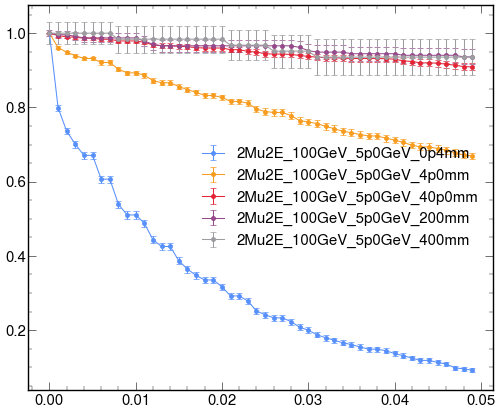

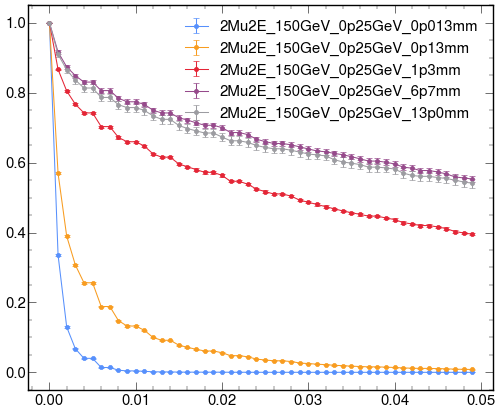

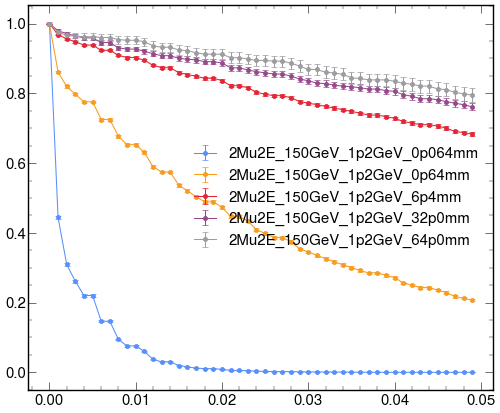

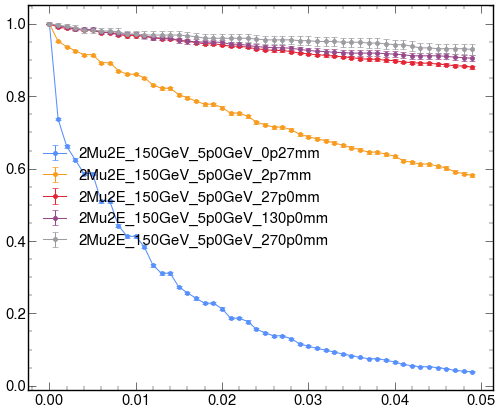

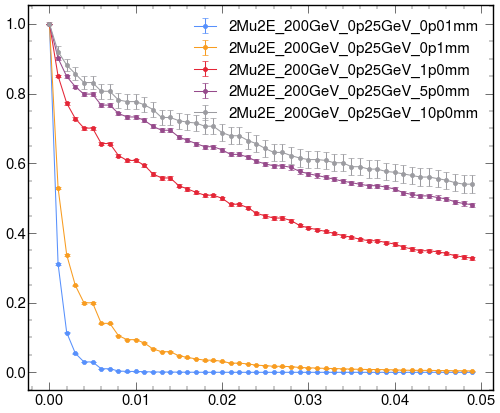

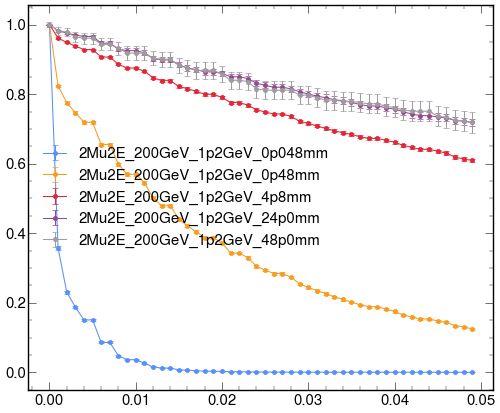

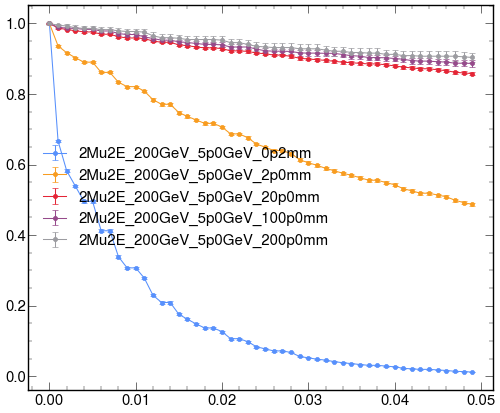

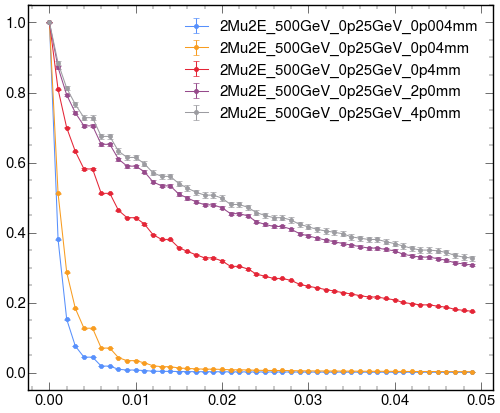

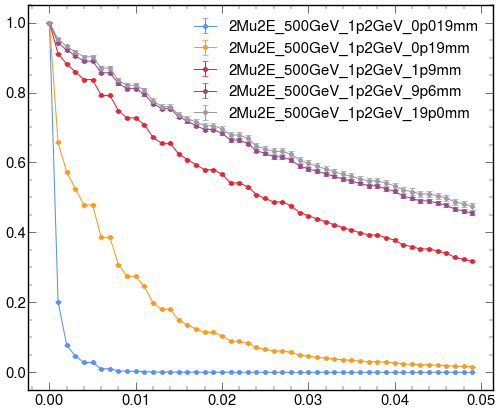

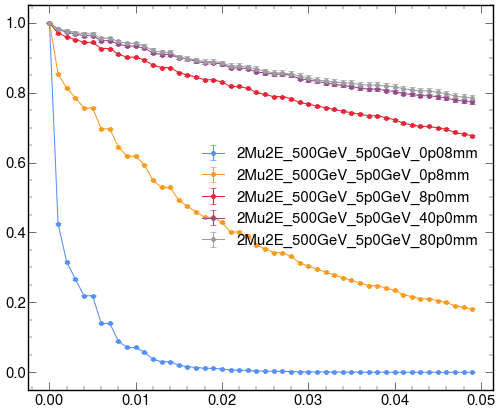

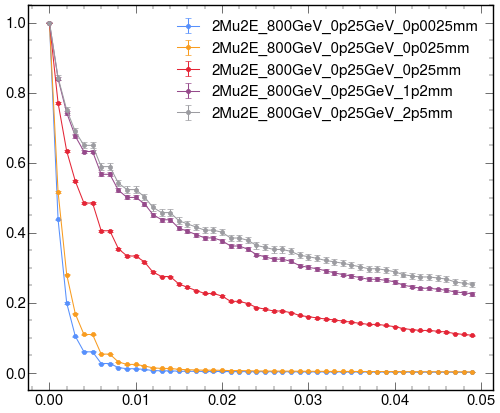

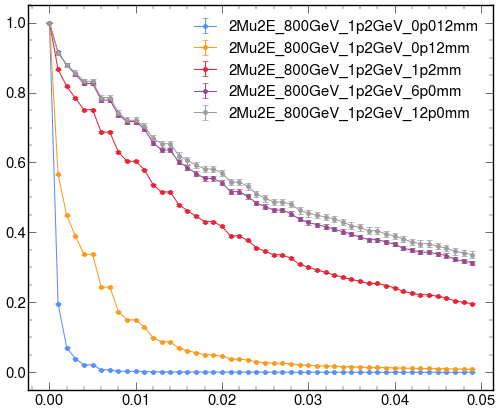

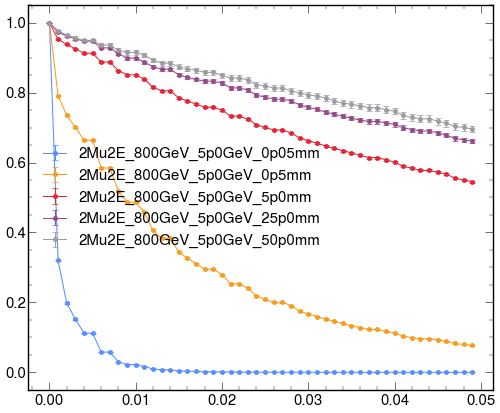

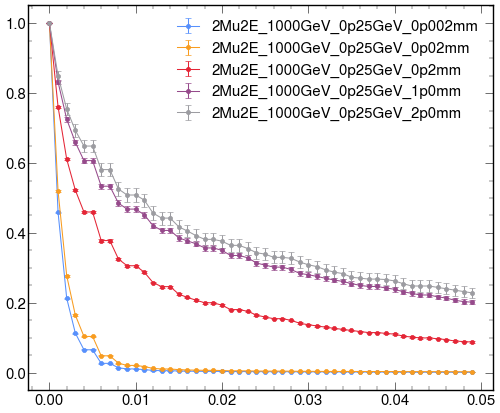

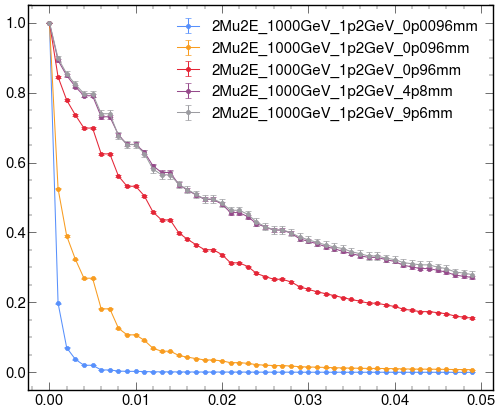

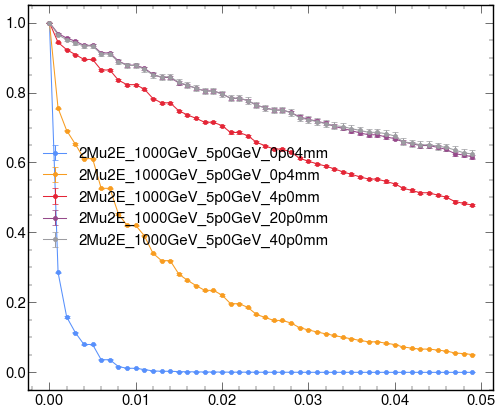

<Figure size 600x500 with 0 Axes>

In [3]:
histogram_name = "mu_lj_pfMuon_min_dxy_XLowRange"
channel_name = "base_ljObjCut_ljIso_2lj"
thresholds = np.arange(0, 0.05, 0.001)


##compute_histgram_stats
def compute_histogram_stats(histogram, threholds):
    values = histogram.values()
    variances = histogram.variances()
    overflow = histogram.values(flow =True)[-1]
    overflow_var = histogram.variances(flow =True)[-1]
    underflow = histogram.values(flow =True)[0]
    underflow_var = histogram.variances(flow =True)[0]
    bin_edges = histogram.axes[0].edges
    n_pass_list = []
    n_pass_sigma_list = []
    n_pass_fraction_list = []
    n_pass_fraction_err_list = []
    n_total = values.sum() + overflow + underflow
    sigma_total = np.sqrt(variances.sum() + overflow_var + underflow_var)
    for x in thresholds:
        idx = np.searchsorted(bin_edges, x, side="right") -1
        idx = max(idx, 0)
        n_pass = values[idx:].sum() + overflow.sum()
        sigma_pass = np.sqrt(variances[idx:].sum() + overflow_var.sum())
        fraction = n_pass / n_total if n_total > 0 else 0

        if n_total > 0 and n_pass > 0:
            num_counts_arr = np.array([n_pass**2 / sigma_pass**2])
            denom_counts_arr = np.array([n_total**2 / sigma_total**2])
            fraction_err = intervals.ratio_uncertainty(
            num_counts_arr,
            denom_counts_arr,
            uncertainty_type='efficiency')[0][0]
        else:
            fraction_err = 0
        n_pass_list.append(n_pass)
        n_pass_sigma_list.append(sigma_pass)
        n_pass_fraction_list.append(fraction)
        n_pass_fraction_err_list.append(fraction_err)
    return n_pass_list, n_total, n_pass_sigma_list, sigma_total, n_pass_fraction_list, n_pass_fraction_err_list



filename = f"output_signal_{channel_name}.coffea"
output_signal=coffea.util.load(filename)
plt.figure(figsize=(12, 10))

for s, sig in enumerate(signals_all):
    histogram = output_signal["out"][sig]["hists"][histogram_name][channel_name, :]
    n_pass, n_total, sigma_pass, sigma_total, fraction, fraction_err = compute_histogram_stats(histogram, thresholds)
    
    plt.errorbar(thresholds, fraction, yerr=fraction_err, fmt='o-', capsize=4, label=sig)
    
    # every 5 signals, show and reset figure
    if (s + 1) % 5 == 0:
        plt.legend()
        plt.show()
        plt.close()
        plt.figure(figsize=(12, 10))

# show any remaining plots (if total not divisible by 5)
if len(signals_all) % 5 != 0:
    plt.legend()
    plt.show()
    plt.close()
    
    










    
    
    
